# Network Intrusion Detection with Graph Attention Networks (GAT)

This notebook implements a Graph Attention Network (GAT) model for network intrusion detection using the UNSW-NB15 dataset. We'll go through the following steps:

1. Loading and preprocessing the UNSW-NB15 dataset
2. Constructing a graph from the network traffic data
3. Implementing a GAT model using PyTorch Geometric
4. Training and evaluating the model
5. Analyzing the results


## 1. Setup and Dependencies

In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn torch torch-geometric

     |████████████████████████████████| 17.3 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 94.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 120.9 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 50.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 106.4 MB/s eta 0:00:01
     |████████████████████████████████| 797.1 MB 21 kB/s /s eta 0:00:01     |███████████████████████████▌    | 685.4 MB 115.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 121.6 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 116.6 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 123.5 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 125.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 122.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 122.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 117.6 MB/s eta 0:00:01
     |███████████

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, Dataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Loading and Preprocessing the UNSW-NB15 Dataset

The UNSW-NB15 dataset contains network traffic data with various features and attack types.

In [3]:
# Load the dataset
# I'll use the files already in the directory: UNSW_2018_IoT_Botnet_Final_10_best_Training.csv and UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv

# Load training set
try:
    train_df = pd.read_csv('UNSW_NB15_training-set.csv')
    print(f"Training dataset loaded successfully. Shape: {train_df.shape}")
except FileNotFoundError:
    print("Training dataset file not found.")
    
# Load testing set
try:
    test_df = pd.read_csv('UNSW_NB15_testing-set.csv')
    print(f"Testing dataset loaded successfully. Shape: {test_df.shape}")
except FileNotFoundError:
    print("Testing dataset file not found.")

# Display basic information about the datasets
print("\nTraining dataset info:")
train_df.info(verbose=False)
print("\nTesting dataset info:")
test_df.info(verbose=False)

Training dataset loaded successfully. Shape: (82332, 45)
Testing dataset loaded successfully. Shape: (175341, 45)

Training dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Columns: 45 entries, id to label
dtypes: float64(11), int64(30), object(4)
memory usage: 28.3+ MB

Testing dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Columns: 45 entries, id to label
dtypes: float64(11), int64(30), object(4)
memory usage: 60.2+ MB


In [4]:
# Display the first few rows of the training dataset
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [5]:
# Check for missing values
train_missing = train_df.isnull().sum()
print("Training columns with missing values:")
print(train_missing[train_missing > 0])

test_missing = test_df.isnull().sum()
print("\nTesting columns with missing values:")
print(test_missing[test_missing > 0])

Training columns with missing values:
Series([], dtype: int64)

Testing columns with missing values:
Series([], dtype: int64)


Using 'label' as the target variable

Distribution in training set:
label
1    45332
0    37000
Name: count, dtype: int64

Percentage:
label
1    55.060001
0    44.939999
Name: proportion, dtype: float64

Distribution in testing set:
label
1    119341
0     56000
Name: count, dtype: int64

Percentage:
label
1    68.062233
0    31.937767
Name: proportion, dtype: float64


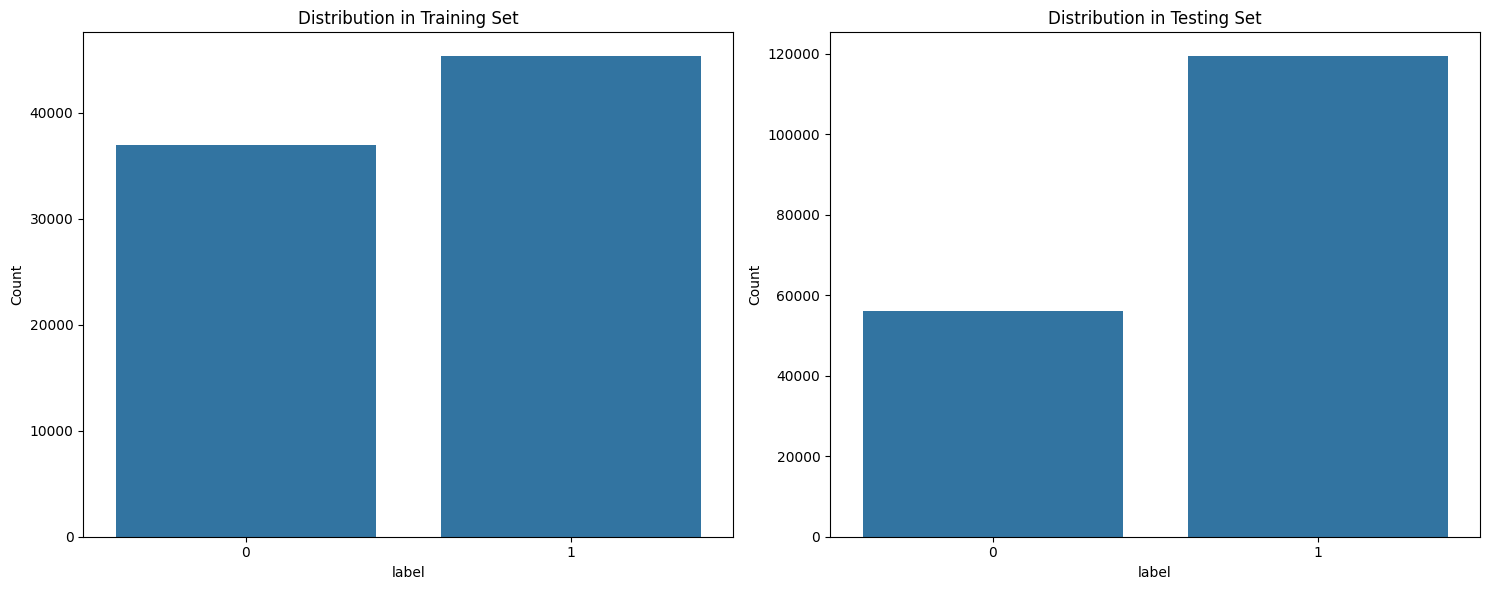

In [6]:
# Check the distribution of the target variable
# Assuming 'attack' or 'label' is the target column - adjust if different
# First determine the label column
label_cols = [col for col in train_df.columns if col.lower() in ['label', 'attack', 'class', 'is_attack']]
if label_cols:
    label_col = label_cols[0]
    print(f"Using '{label_col}' as the target variable")
    
    print("\nDistribution in training set:")
    print(train_df[label_col].value_counts())
    print("\nPercentage:")
    print(train_df[label_col].value_counts(normalize=True) * 100)
    
    print("\nDistribution in testing set:")
    print(test_df[label_col].value_counts())
    print("\nPercentage:")
    print(test_df[label_col].value_counts(normalize=True) * 100)
    
    # Plot the distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.countplot(x=label_col, data=train_df, ax=axes[0])
    axes[0].set_title('Distribution in Training Set')
    axes[0].set_ylabel('Count')
    
    sns.countplot(x=label_col, data=test_df, ax=axes[1])
    axes[1].set_title('Distribution in Testing Set')
    axes[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not identify the target column. Please specify the correct column name.")

## 3. Data Preprocessing and Feature Engineering

In [7]:
# Identify categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove the target variable from the feature lists
if label_col in numerical_features:
    numerical_features.remove(label_col)
if label_col in categorical_features:
    categorical_features.remove(label_col)

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

Categorical features: ['proto', 'service', 'state', 'attack_cat']
Numerical features: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [8]:
# Handle missing values
# Replace missing values in numerical features with median
for col in numerical_features:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_val)
        test_df[col] = test_df[col].fillna(median_val)

# Replace missing values in categorical features with the most frequent value
for col in categorical_features:
    if train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_val)
        test_df[col] = test_df[col].fillna(mode_val)

# Verify no missing values remain
print("Remaining missing values in training set:")
print(train_df.isnull().sum().sum())
print("Remaining missing values in testing set:")
print(test_df.isnull().sum().sum())

Remaining missing values in training set:
0
Remaining missing values in testing set:
0


In [9]:
# Create a preprocessing pipeline
# One-hot encode categorical features and standardize numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Extract features and target variable
X_train = train_df.drop([label_col], axis=1)
y_train = train_df[label_col]
X_test = test_df.drop([label_col], axis=1)
y_test = test_df[label_col]

# Apply the preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Training set shape after transformation: {X_train_transformed.shape}")
print(f"Testing set shape after transformation: {X_test_transformed.shape}")

Training set shape after transformation: (82332, 201)
Testing set shape after transformation: (175341, 201)


## 4. Graph Construction

For GAT, we need to represent the data as a graph. We'll create a graph where each node represents a network flow and edges connect similar flows.

In [10]:
# Convert sparse matrix to dense if needed
if hasattr(X_train_transformed, 'toarray'):
    X_train_transformed = X_train_transformed.toarray()
if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()

# Create kNN graph for training data
def create_knn_graph(features, k=10):
    """Create a k-nearest neighbors graph from features."""
    from sklearn.neighbors import kneighbors_graph
    # Create adjacency matrix using k-nearest neighbors
    adjacency = kneighbors_graph(features, n_neighbors=k, mode='connectivity', include_self=False)
    # Convert to symmetric adjacency matrix
    adjacency = adjacency.maximum(adjacency.transpose())
    # Get edge indices from sparse adjacency matrix
    edge_indices = np.array(adjacency.nonzero())
    return edge_indices

# Create graphs for training and testing data
train_edge_index = create_knn_graph(X_train_transformed, k=10)
test_edge_index = create_knn_graph(X_test_transformed, k=10)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_transformed).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
train_edge_index_tensor = torch.LongTensor(train_edge_index).to(device)

X_test_tensor = torch.FloatTensor(X_test_transformed).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)
test_edge_index_tensor = torch.LongTensor(test_edge_index).to(device)

# Create PyTorch Geometric Data objects
train_data = Data(x=X_train_tensor, edge_index=train_edge_index_tensor, y=y_train_tensor)
test_data = Data(x=X_test_tensor, edge_index=test_edge_index_tensor, y=y_test_tensor)

print(f"Training graph: {train_data}")
print(f"Testing graph: {test_data}")

Training graph: Data(x=[82332, 201], edge_index=[2, 1088170], y=[82332])
Testing graph: Data(x=[175341, 201], edge_index=[2, 2314854], y=[175341])


## 5. Graph Attention Network (GAT) Model Implementation

In [11]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        # After first GAT layer, feature size is hidden_channels * heads
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=0.3)
        self.out = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        # First Graph Attention Layer with multiple heads
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Using ELU activation as recommended in the GAT paper
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Second Graph Attention Layer with a single head
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Output Layer
        x = self.out(x)
        
        return x

In [12]:
# Determine the number of output classes
num_classes = len(y_train.unique())
print(f"Number of classes: {num_classes}")

# Initialize the model
model = GAT(
    in_channels=X_train_transformed.shape[1],  # Number of input features
    hidden_channels=16,                        # Hidden layer size (smaller than GCN as we use multiple heads)
    out_channels=num_classes,                  # Number of classes
    heads=8                                    # Number of attention heads
).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print(model)

Number of classes: 2
GAT(
  (conv1): GATConv(201, 16, heads=8)
  (conv2): GATConv(128, 16, heads=1)
  (out): Linear(in_features=16, out_features=2, bias=True)
)


## 6. Training the GAT Model

In [13]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    out = model(data.x, data.edge_index)
    # Calculate loss
    loss = criterion(out, data.y)
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum().item()
        acc = correct / data.y.size(0)
    return acc, pred

In [14]:
# Training loop
epochs = 200
best_val_acc = 0
losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    # Train
    loss = train(model, train_data, optimizer, criterion)
    losses.append(loss)
    
    # Evaluate on training and testing data
    train_acc, _ = evaluate(model, train_data)
    test_acc, _ = evaluate(model, test_data)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Save the best model
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        torch.save(model.state_dict(), 'best_gat_model.pt')

Epoch: 010, Loss: 0.2872, Train Acc: 0.9466, Test Acc: 0.7605
Epoch: 020, Loss: 0.0609, Train Acc: 0.9908, Test Acc: 0.5906
Epoch: 030, Loss: 0.0284, Train Acc: 0.9957, Test Acc: 0.5965
Epoch: 040, Loss: 0.0192, Train Acc: 0.9961, Test Acc: 0.7120
Epoch: 050, Loss: 0.0147, Train Acc: 0.9967, Test Acc: 0.8782
Epoch: 060, Loss: 0.0124, Train Acc: 0.9970, Test Acc: 0.9533
Epoch: 070, Loss: 0.0111, Train Acc: 0.9975, Test Acc: 0.9786
Epoch: 080, Loss: 0.0104, Train Acc: 0.9977, Test Acc: 0.9902
Epoch: 090, Loss: 0.0102, Train Acc: 0.9978, Test Acc: 0.9932
Epoch: 100, Loss: 0.0095, Train Acc: 0.9978, Test Acc: 0.9943
Epoch: 110, Loss: 0.0094, Train Acc: 0.9979, Test Acc: 0.9954
Epoch: 120, Loss: 0.0092, Train Acc: 0.9978, Test Acc: 0.9960
Epoch: 130, Loss: 0.0088, Train Acc: 0.9978, Test Acc: 0.9961
Epoch: 140, Loss: 0.0085, Train Acc: 0.9980, Test Acc: 0.9961
Epoch: 150, Loss: 0.0086, Train Acc: 0.9980, Test Acc: 0.9962
Epoch: 160, Loss: 0.0083, Train Acc: 0.9980, Test Acc: 0.9962
Epoch: 1

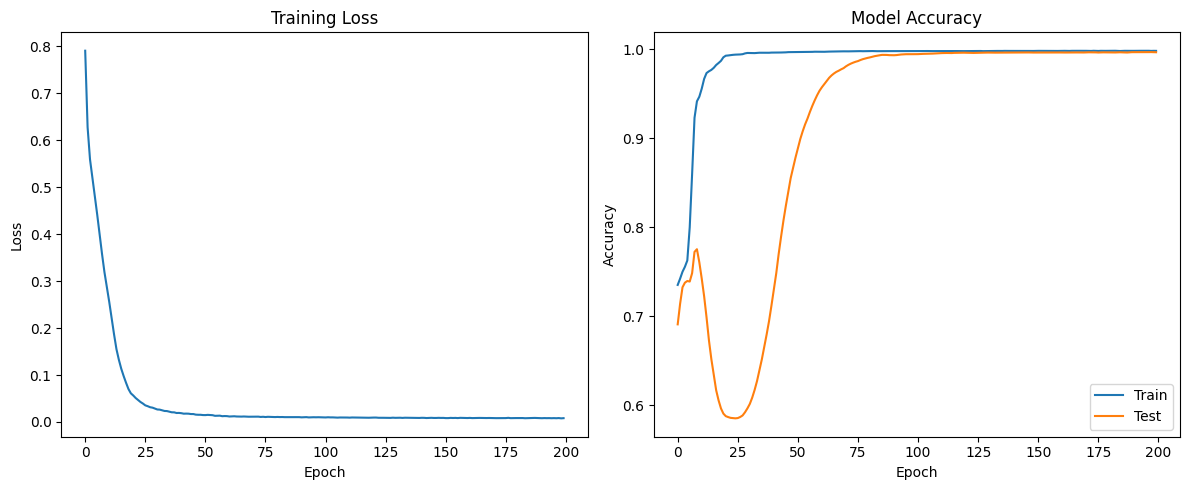

In [15]:
# Plot training metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluating the Best Model

In [16]:
# Load the best model
best_model = GAT(
    in_channels=X_train_transformed.shape[1],
    hidden_channels=16,
    out_channels=num_classes,
    heads=8
).to(device)
best_model.load_state_dict(torch.load('best_gat_model.pt'))

# Evaluate on test data
best_model.eval()
with torch.no_grad():
    out = best_model(test_data.x, test_data.edge_index)
    pred = out.argmax(dim=1)
    
# Convert predictions to numpy for evaluation
y_true = test_data.y.cpu().numpy()
y_pred = pred.cpu().numpy()

/tmp/ipykernel_814187/2506283776.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_gat_model.pt'))


Accuracy: 0.9967
Precision: 0.9963
Recall: 0.9988
F1 Score: 0.9976


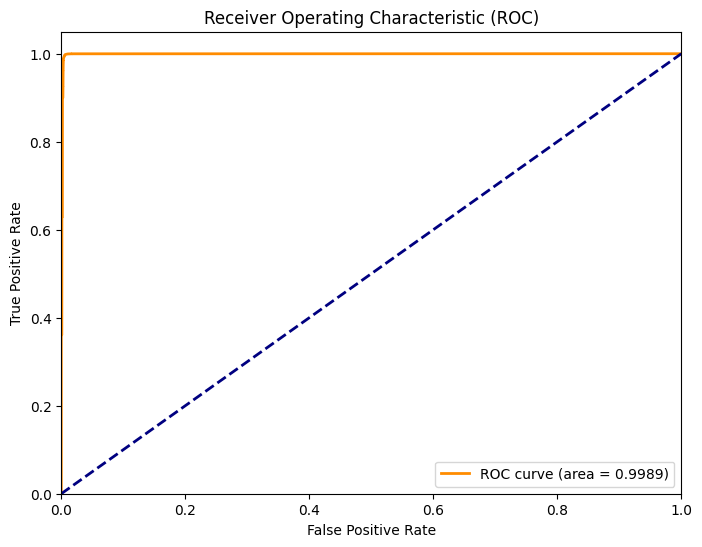

In [17]:
# Calculate evaluation metrics for binary and multi-class classification
if num_classes == 2:
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Compute probabilities for ROC curve
    with torch.no_grad():
        probabilities = F.softmax(out, dim=1)[:, 1].cpu().numpy()
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    # Multi-class metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")

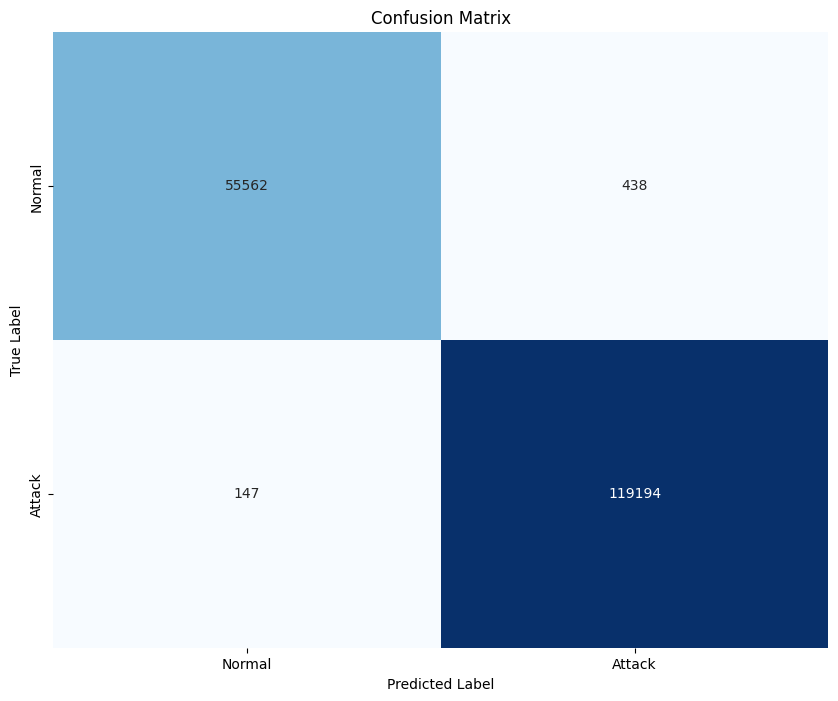

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))

# For binary classification
if num_classes == 2:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
# For multi-class classification
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 8. Conclusion

In this notebook, we have implemented a Graph Attention Network (GAT) for network intrusion detection using the UNSW-NB15 dataset. The GAT model extends the GCN by incorporating attention mechanisms that can learn to assign different weights to different neighbors, potentially capturing more complex patterns in the data.

The evaluation metrics show how well our GAT model performs on the binary classification task of identifying network intrusions. This approach demonstrates the potential of attention-based graph neural networks for cybersecurity applications.

Next steps could include:
1. Comparing the performance of GAT with GCN and other traditional machine learning models
2. Experimenting with different attention mechanisms and graph construction methods
3. Enhancing the model to perform multi-class classification to identify specific types of attacks
4. Investigating the interpretability of attention weights to understand which features are most important for intrusion detection

## 9. Comparison with GCN Model

To complete our analysis, we can directly compare the GAT model with the GCN model implementation. This comparison helps us understand the benefits of using attention mechanisms in the context of network intrusion detection.

Comparison of GCN and GAT models:

      Metric       GCN       GAT
0   Accuracy  0.996840  0.996664
1  Precision  0.996556  0.996339
2     Recall  0.998810  0.998768
3   F1 Score  0.997682  0.997552
4        AUC  0.997945  0.998938


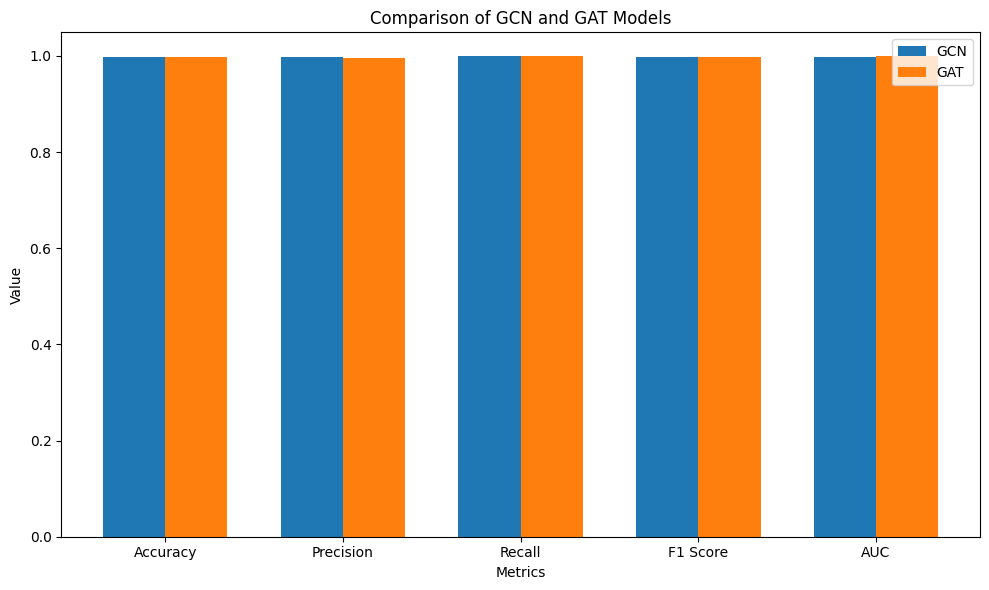

In [19]:
# If you've run the GCN notebook, you can load those results here for comparison
import pickle

# Load GCN results if available
try:
    with open('gcn_results.pkl', 'rb') as f:
        gcn_results = pickle.load(f)
    
    # Save GAT results
    if num_classes == 2:
        gat_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
    else:
        gat_results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro
        }
    
    with open('gat_results.pkl', 'wb') as f:
        pickle.dump(gat_results, f)
    
    # Create comparison table
    if num_classes == 2:
        comparison_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
            'GCN': [gcn_results['accuracy'], gcn_results['precision'], 
                    gcn_results['recall'], gcn_results['f1'], gcn_results['roc_auc']],
            'GAT': [gat_results['accuracy'], gat_results['precision'], 
                    gat_results['recall'], gat_results['f1'], gat_results['roc_auc']]
        })
    else:
        comparison_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score'],
            'GCN': [gcn_results['accuracy'], gcn_results['precision_macro'], 
                    gcn_results['recall_macro'], gcn_results['f1_macro']],
            'GAT': [gat_results['accuracy'], gat_results['precision_macro'], 
                    gat_results['recall_macro'], gat_results['f1_macro']]
        })
    
    print("Comparison of GCN and GAT models:\n")
    print(comparison_df)
    
    # Visualize the comparison
    plt.figure(figsize=(10, 6))
    
    # Set up the bar positions
    bar_width = 0.35
    metrics = comparison_df['Metric']
    index = np.arange(len(metrics))
    
    # Create the bars
    plt.bar(index, comparison_df['GCN'], bar_width, label='GCN')
    plt.bar(index + bar_width, comparison_df['GAT'], bar_width, label='GAT')
    
    # Customize the plot
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Comparison of GCN and GAT Models')
    plt.xticks(index + bar_width / 2, metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("GCN results file not found. Run the GCN notebook first to generate results for comparison.")
    
    # Save GAT results anyway
    if num_classes == 2:
        gat_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
    else:
        gat_results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro
        }
    
    with open('gat_results.pkl', 'wb') as f:
        pickle.dump(gat_results, f)
    
    print("GAT results saved for future comparison.")